User_Goal{
User_Goal_1{실거래 데이터를 기반으로 서울, 경기, 인천 광역시의 부동산 가격 변동 패턴을 비교 분석하고, 지역별 시장 특성과 투자 매력도를 평가},
User_Goal_2{},
User_Goal_3{}
}
// User_Goal_2, User_Goal_3는 추후 사용자가 공개

----User Requirements
* User Requirements는 Claude에게 user가 요청하는 내용이고 이것은 누락되지 않고 추가 할 예정
* 나는 ipynb파일에서 코드 블록에서 파이썬 인터프린터를 실행하면서 해보고 있어
* 그래서 코드를 기능별로 실행 가능한 단위에서 코드 블록으로 나눠서 작업 해야 해
* Claude는 코드 생성 또는 수정 전에 꼭 나에게 꼭 설명, 질문, 허락을 구하는 절차를 구해야해 (important) 
* 현재의 프롬프트에서 지속적으로 필요하지 않은 맥락이 있다면 알려줘 (right now)
----Condition

jaehyuntak@Jaehyunui-MacBookAir pjt-data-analysis 
.
├── README.md
├── csv_encoder_converter_combiner.py
├── da_utils
├── local_combine_geminie.ipynb
├── preprocess_20240820_20250819.ipynb
├── preprocess_combine.ipynb
├── preprocess_combine_Ic_apt .py
├── preprocess_combine_seoul_apt.py
├── preprocess_with_da_utils.py
├── raw_data
├── requirements.txt
└── venv

/Users/jaehyuntak/Desktop/pjt-data-analysis/data_row 폴더 안에 220820-250819combined_capital_area_apt_sales.csv라는 csv파일이 있고

아래는 csv 데이터의 샘플이고
"""
NO,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),동,층,매수자,매도자,건축년도,도로명,해제사유발생일,거래유형,중개사소재지,등기일자
1,경기도 수원시 영통구 영통동,969-1,969,1,태영,84.91,202308,19,"64,000",935,17,-,-,1997,봉영로1517번길 73,-,중개거래,경기 수원영통구,23.12.28
2,경기도 수원시 장안구 정자동,313-1,313,1,동신2단지,43.02,202308,19,"19,000",213,5,-,-,1988,장안로 211,-,중개거래,경기 수원장안구,23.10.06
"""

 da_utils 파일의 모듈을 이용해서 결점치, 이상치, 종합 데이터 품질 리포트( 변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%), 유일값비율(%), 일변량, Mahal Dist, Iso Forest, 총이상값수)를 해주는 파이썬 코드를 이용한 결과를 파일로 첨부했어

# 'data_cleaning.ipynb' 

📁 분석 대상 파일
파일명
220820-250819combined_capital_area_apt_sales.csv
전체 경로
/Users/jaehyuntak/Desktop/pjt-data-analysis/raw_data/220820-250819combined_capital_area_apt_sales.csv
파일 정보
데이터 기간: 2022년 8월 20일 ~ 2025년 8월 19일
지역 범위: 수도권 (서울, 경기, 인천)
데이터 유형: 아파트 실거래가
총 레코드 수: 555,362건



In [4]:
# 1. 환경 설정 및 데이터 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from da_utils.font import setup_korean_font

# 한글 폰트 설정 (한 번만 호출하면 됨)
setup_korean_font()

✅ Korean font set successfully: AppleGothic


# Claude Work Flow

세부 작업 계획
1️⃣ 데이터 로드 및 기본 탐색 (현재 완료)
✅ 라이브러리 import
✅ 한글 폰트 설정
 CSV 파일 로드
 데이터 shape, dtypes 확인
 메모리 사용량 확인

2️⃣ 결측치 분석 및 처리
2-1. 명시적 결측치 (NaN)

 결측치 개수 및 비율 확인
 결측 패턴 시각화
 register_date 결측치 유지 (결정사항)

2-2. 암묵적 결측치 ('-' 문자)

 '-' 문자 포함 필드 식별
 거래유형별 결측 패턴 분석
 필드별 처리 전략 적용

3️⃣ 이상치 탐지 및 처리
3-1. 일변량 이상치

 IQR 방법으로 탐지
 박스플롯 시각화
 변수별 임계값 설정

3-2. 다변량 이상치

 마할라노비스 거리
 Isolation Forest
 종합 이상치 판정

3-3. 이상치 처리

 처리 전략 선택 (제거/대체/유지)
 도메인 지식 기반 검증
 처리 전후 비교

4️⃣ 최종 검증 및 저장

 데이터 품질 재검증
 처리 결과 요약 리포트
 정제된 데이터 저장

In [6]:
# 2. 데이터 로드
file_path = '/Users/jaehyuntak/Desktop/pjt-data-analysis/raw_data/220820-250819combined_capital_area_apt_sales.csv'
df = pd.read_csv(file_path, encoding='utf-8')

print("=== 데이터 로드 완료 ===")
print(f"데이터 크기: {df.shape[0]:,}행 × {df.shape[1]}열")
print(f"메모리 사용량: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\n=== 데이터 미리보기 ===")
df.head()

=== 데이터 로드 완료 ===
데이터 크기: 555,362행 × 22열
메모리 사용량: 529.44 MB

=== 데이터 미리보기 ===


,NO,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),...,매수자,매도자,건축년도,도로명,해제사유발생일,거래유형,중개사소재지,등기일자,지역,계약일자
0,83197,경기도 용인시 수지구 죽전동,1182,1182,0,내대지마을건영캐스빌,110.3495,202208,20,"81,500",...,-,-,2004,죽전로 267,-,중개거래,경기 용인수지구,-,경기,2022-08-20
1,83196,경기도 군포시 산본동,1155-7,1155,7,가야3주공,42.7500,202208,20,"25,000",...,-,-,1993,번영로 353,-,중개거래,경기 군포시,-,경기,2022-08-20
2,83195,경기도 의왕시 포일동,645,645,0,인덕원숲속마을3단지,74.8400,202208,20,"82,000",...,-,-,2011,포일세거리로 93,-,중개거래,경기 의왕시,-,경기,2022-08-20
3,83194,경기도 군포시 금정동,875,875,0,퇴계주공(351~359동),41.8500,202208,20,"30,500",...,-,-,1993,광정로 25-20,-,중개거래,경기 군포시,-,경기,2022-08-20
4,83193,경기도 하남시 감이동,500,500,0,포웰시티푸르지오라포레,99.4327,202208,20,"119,000",...,-,-,2021,감일백제로 20,20221212,직거래,-,-,경기,2022-08-20


In [7]:
# 3. 데이터 타입 및 컬럼 정보 확인
print("=== 데이터 타입 정보 ===")
print(df.dtypes)
print("\n=== 각 컬럼별 고유값 개수 ===")
for col in df.columns:
    unique_count = df[col].nunique()
    print(f"{col}: {unique_count:,}개")

=== 데이터 타입 정보 ===
NO            int64
시군구          object
번지           object
본번            int64
부번            int64
단지명          object
전용면적(㎡)     float64
계약년월          int64
계약일           int64
거래금액(만원)     object
동            object
층             int64
매수자          object
매도자          object
건축년도          int64
도로명          object
해제사유발생일      object
거래유형         object
중개사소재지       object
등기일자         object
지역           object
계약일자         object
dtype: object

=== 각 컬럼별 고유값 개수 ===
NO: 330,055개
시군구: 1,043개
번지: 8,704개
본번: 1,982개
부번: 303개
단지명: 13,099개
전용면적(㎡): 19,277개
계약년월: 37개
계약일: 31개
거래금액(만원): 6,631개
동: 4,347개
층: 70개
매수자: 5개
매도자: 5개
건축년도: 62개
도로명: 16,130개
해제사유발생일: 1,029개
거래유형: 2개
중개사소재지: 4,711개
등기일자: 648개
지역: 3개
계약일자: 1,096개


In [8]:
# 4. 숫자형 컬럼 기본 통계
print("=== 숫자형 컬럼 기본 통계 ===")
numeric_stats = df.describe()
numeric_stats

=== 숫자형 컬럼 기본 통계 ===


,NO,본번,부번,전용면적(㎡),계약년월,계약일,층,건축년도
count,555362.000000,555362.000000,555362.000000,555362.000000,555362.000000,555362.000000,555362.000000,555362.000000
mean,123162.159093,756.911164,3.574427,75.867227,202397.320631,15.806993,10.430517,2005.675161
std,92903.807330,787.603299,30.823901,25.323296,83.909603,8.660420,7.051663,10.740214
min,1.000000,0.000000,0.000000,9.410000,202208.000000,1.000000,-3.000000,1961.000000
25%,46281.000000,329.000000,0.000000,59.850000,202308.000000,8.000000,5.000000,1997.000000
50%,100123.500000,653.000000,0.000000,79.984000,202406.000000,16.000000,9.000000,2005.000000
75%,191214.750000,959.000000,1.000000,84.960000,202502.000000,23.000000,14.000000,2016.000000
max,330055.000000,7346.000000,2837.000000,309.700000,202508.000000,31.000000,68.000000,2025.000000


In [9]:
# 5. 결측치 분석 - 명시적 결측치(NaN) 확인
print("=== 명시적 결측치(NaN) 분석 ===")
null_counts = df.isnull().sum()
null_percentages = (df.isnull().sum() / len(df)) * 100
null_summary = pd.DataFrame({
    '결측치 개수': null_counts,
    '결측치 비율(%)': null_percentages
})
null_summary = null_summary[null_summary['결측치 개수'] > 0].sort_values('결측치 비율(%)', ascending=False)
print(null_summary)

=== 명시적 결측치(NaN) 분석 ===
Empty DataFrame
Columns: [결측치 개수, 결측치 비율(%)]
Index: []


In [20]:
# 6. 암묵적 결측치 ('-' 문자) 분석
print("\n=== 암묵적 결측치 ('-' 문자) 분석 ===")
dash_counts = {}
for col in df.columns:
    if df[col].dtype == 'object':  # 문자열 컬럼만 확인
        dash_count = (df[col] == '-').sum()
        if dash_count > 0:
            dash_counts[col] = {
                '개수': dash_count,
                '비율(%)': (dash_count / len(df)) * 100
            }

if dash_counts:
    dash_summary = pd.DataFrame(dash_counts).T
    print(dash_summary.sort_values('비율(%)', ascending=False))
else:
    print("'-' 문자로 표시된 결측치가 없습니다.")


=== 암묵적 결측치 ('-' 문자) 분석 ===
               개수      비율(%)
해제사유발생일  524435.0  94.431200
매수자      184784.0  33.272712
매도자      184784.0  33.272712
동        123092.0  22.164282
등기일자     104753.0  18.862112
중개사소재지    30962.0   5.575102


In [21]:
# 7. 날짜 관련 컬럼 확인
print("=== 날짜 관련 컬럼 확인 ===")
date_columns = [col for col in df.columns if '날짜' in col or '일자' in col or 'date' in col.lower()]
print(f"날짜 관련 컬럼: {date_columns}")

# 날짜 컬럼의 데이터 타입 확인
for col in date_columns:
    print(f"{col}: {df[col].dtype}")

=== 날짜 관련 컬럼 확인 ===
날짜 관련 컬럼: ['등기일자', '계약일자', '계약날짜']
등기일자: object
계약일자: object
계약날짜: datetime64[ns]


In [22]:
# 컬럼 목록 재확인
print("\n=== 전체 컬럼 목록 ===")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")


=== 전체 컬럼 목록 ===
 1. NO
 2. 시군구
 3. 번지
 4. 본번
 5. 부번
 6. 단지명
 7. 전용면적(㎡)
 8. 계약년월
 9. 계약일
10. 거래금액(만원)
11. 동
12. 층
13. 매수자
14. 매도자
15. 건축년도
16. 도로명
17. 해제사유발생일
18. 거래유형
19. 중개사소재지
20. 등기일자
21. 지역
22. 계약일자
23. 계약날짜


In [23]:
# 8. 날짜 컬럼 중복 확인
print("=== 날짜 관련 컬럼 상세 확인 ===")
date_cols = ['계약년월', '계약일', '계약일자', '계약날짜']

for col in date_cols:
    if col in df.columns:
        print(f"\n[{col}]")
        print(f"데이터 타입: {df[col].dtype}")
        print(f"샘플 데이터: {df[col].head(3).tolist()}")
        print(f"고유값 수: {df[col].nunique()}")

# 계약일자와 계약날짜가 같은지 확인
if '계약일자' in df.columns and '계약날짜' in df.columns:
    print("\n=== 계약일자와 계약날짜 비교 ===")
    # 문자열로 변환해서 비교
    same_values = (df['계약일자'].astype(str) == df['계약날짜'].astype(str)).all()
    print(f"두 컬럼이 완전히 동일한가? {same_values}")
    
    if not same_values:
        print("\n다른 값 샘플:")
        diff_mask = df['계약일자'].astype(str) != df['계약날짜'].astype(str)
        print(df[diff_mask][['계약일자', '계약날짜']].head())

=== 날짜 관련 컬럼 상세 확인 ===

[계약년월]
데이터 타입: int64
샘플 데이터: [202208, 202208, 202208]
고유값 수: 37

[계약일]
데이터 타입: int64
샘플 데이터: [20, 20, 20]
고유값 수: 31

[계약일자]
데이터 타입: object
샘플 데이터: ['2022-08-20', '2022-08-20', '2022-08-20']
고유값 수: 1096

[계약날짜]
데이터 타입: datetime64[ns]
샘플 데이터: [Timestamp('2022-08-20 00:00:00'), Timestamp('2022-08-20 00:00:00'), Timestamp('2022-08-20 00:00:00')]
고유값 수: 1096

=== 계약일자와 계약날짜 비교 ===
두 컬럼이 완전히 동일한가? True


In [25]:
# 9. 중복 날짜 컬럼 처리
print("=== 날짜 컬럼 정리 ===")
# 계약날짜(datetime)만 남기고 계약일자(문자열) 삭제
df_clean = df.drop(columns=['계약일자'])
print(f"삭제된 컬럼: 계약일자 (계약날짜와 중복)")
print(f"현재 컬럼 수: {len(df_clean.columns)}개")

=== 날짜 컬럼 정리 ===
삭제된 컬럼: 계약일자 (계약날짜와 중복)
현재 컬럼 수: 22개


In [ ]:
# 10. '-' 문자를 NaN으로 변환
print("\n=== '-' 문자를 NaN으로 변환 ===")
# 변환 전 상태 저장
dash_columns = ['해제사유발생일', '매수자', '매도자', '동', '등기일자', '중개사소재지']

for col in dash_columns:
    before_count = (df_clean[col] == '-').sum()
    df_clean[col] = df_clean[col].replace('-', np.nan)
    after_count = df_clean[col].isna().sum()
    print(f"{col}: {before_count:,}개 '-' → {after_count:,}개 NaN")


=== '-' 문자를 NaN으로 변환 ===
해제사유발생일: 524,435개 '-' → 524,435개 NaN
매수자: 184,784개 '-' → 184,784개 NaN
매도자: 184,784개 '-' → 184,784개 NaN
동: 123,092개 '-' → 123,092개 NaN
등기일자: 104,753개 '-' → 104,753개 NaN
중개사소재지: 30,962개 '-' → 30,962개 NaN


In [29]:
# 12. 등기일자 datetime 변환 시도
print("\n=== 등기일자 datetime 변환 ===")
# 등기일자 샘플 확인
print("변환 전 등기일자 샘플:")
print(df_clean['등기일자'].dropna().head())

# datetime으로 변환 시도
df_clean['등기일자'] = pd.to_datetime(df_clean['등기일자'], format='%y.%m.%d', errors='coerce')
print(f"\n변환 성공: {df_clean['등기일자'].notna().sum():,}건")
print(f"변환 실패 또는 원래 NaN: {df_clean['등기일자'].isna().sum():,}건")


=== 등기일자 datetime 변환 ===
변환 전 등기일자 샘플:
20772    23.01.30
20773    23.03.08
20774    23.03.20
20775    23.02.27
20776    23.03.15
Name: 등기일자, dtype: object

변환 성공: 450,609건
변환 실패 또는 원래 NaN: 104,753건



=== 결측치 처리 후 데이터 품질 재검증 ===

[1] 데이터 프로파일링...
종합 데이터 품질 리포트

1. 기본정보
- 데이터 크기: 555362행 x 22열
- 메모리 사용량: 526.26mb
- 수치형 변수: 8 개
- 범주형 변수: 12 개

2. 결측값 분석
⚠️


,결측수,결측율(%)
동,123092,22.16
매수자,184784,33.27
매도자,184784,33.27
해제사유발생일,524435,94.43
중개사소재지,30962,5.58
등기일자,104753,18.86



3. 수치형 변수 품질 분석


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,NO,123162.159,92903.807,1.00,330055.0,0.644,-0.757,0.000,59.431
1,본번,756.911,787.603,0.00,7346.0,4.481,28.633,2.785,0.357
2,부번,3.574,30.824,0.00,2837.0,33.197,1740.710,14.104,0.055
3,전용면적(㎡),75.867,25.323,9.41,309.7,1.062,3.606,6.808,3.471
4,계약년월,202397.321,83.910,202208.00,202508.0,-0.201,-0.915,0.000,0.007
5,계약일,15.807,8.660,1.00,31.0,-0.011,-1.160,0.000,0.006
6,층,10.431,7.052,-3.00,68.0,1.133,2.179,2.201,0.013
7,건축년도,2005.675,10.740,1961.00,2025.0,-0.163,-0.879,0.008,0.011



4. 분포 이상 감지

- 극심한 왜도 (|skewness|>2)
⚠️
-- 본번: 왜도 = 4.481
-- 부번: 왜도 = 33.197

- 높은 이상값 비율(>5%)
⚠️
-- 부번: 이상값 14.1%
-- 전용면적(㎡): 이상값 6.8%
       변수명          평균       표준편차        최솟값       최댓값      왜도        첨도  \
0       NO  123162.159  92903.807       1.00  330055.0   0.644    -0.757   
1       본번     756.911    787.603       0.00    7346.0   4.481    28.633   
2       부번       3.574     30.824       0.00    2837.0  33.197  1740.710   
3  전용면적(㎡)      75.867     25.323       9.41     309.7   1.062     3.606   
4     계약년월  202397.321     83.910  202208.00  202508.0  -0.201    -0.915   
5      계약일      15.807      8.660       1.00      31.0  -0.011    -1.160   
6        층      10.431      7.052      -3.00      68.0   1.133     2.179   
7     건축년도    2005.675     10.740    1961.00    2025.0  -0.163    -0.879   

   이상값비율(%)  유일값비율(%)  
0     0.000    59.431  
1     2.785     0.357  
2    14.104     0.055  
3     6.808     3.471  
4     0.000     0.007  
5     0.000     0.006  
6     2.20

,결측수,결측률(%)
해제사유발생일,524435,94.43
매수자,184784,33.27
매도자,184784,33.27
동,123092,22.16
등기일자,104753,18.86
중개사소재지,30962,5.58


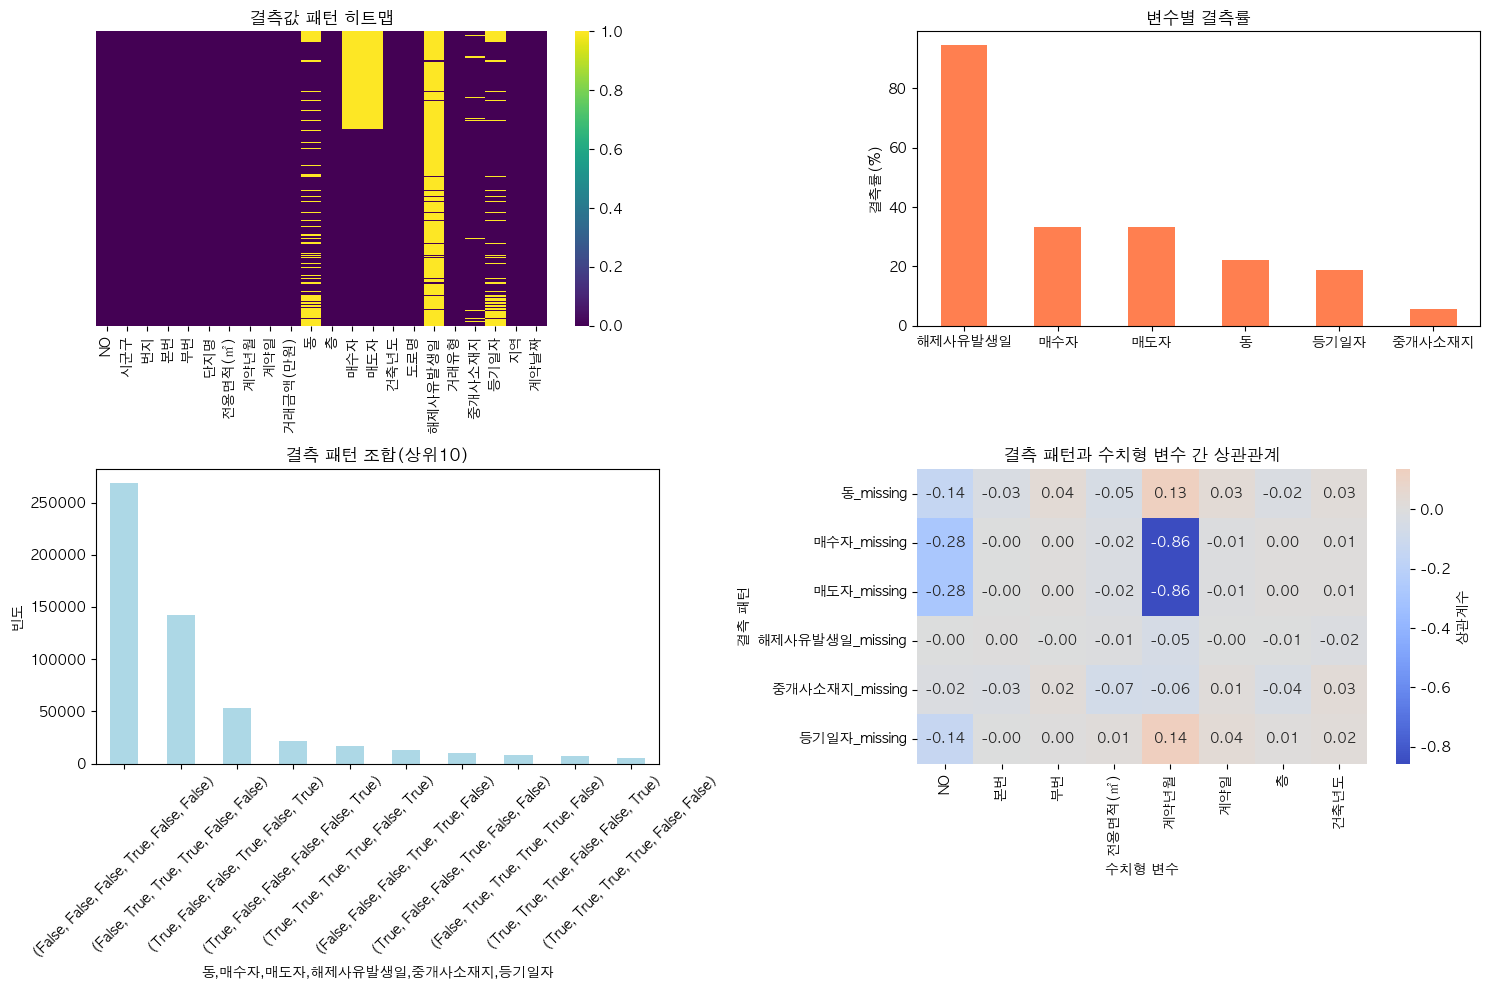

            결측수  결측률(%)
해제사유발생일  524435   94.43
매수자      184784   33.27
매도자      184784   33.27
동        123092   22.16
등기일자     104753   18.86
중개사소재지    30962    5.58

[3] 이상치 패턴 분석...
=== 종합 이상값 탐지 시스템 ===
1. 일변량 이상값 탐지 (IQR방법)
  본번: 15468개 (2.8%)
  부번: 78329개 (14.1%)
  전용면적(㎡): 37810개 (6.8%)
  층: 12224개 (2.2%)
  건축년도: 43개 (0.0%)

2. 다변량 이상값 탐지 (마할라노비스 거리)
  임계값: 5.11
  다변량 이상값: 12182개 (2.2%)

3. 다변량 이상값 탐지 (Isolation Forest)
  Isolation Forest 이상값: 55537개 (10.0%)

 == 최종 이상값: 46139개 (8.3%)
(          일변량  Mahal Dist  Iso Forest  총이상값수
0       False       False       False      0
1        True       False        True      2
2       False       False       False      0
3       False       False        True      1
4       False       False       False      0
...       ...         ...         ...    ...
555357  False       False       False      0
555358  False       False       False      0
555359  False       False       False      0
555360   True       False       False      1
555361

In [31]:
# 12. 처리된 데이터 복사본 생성
df_clean_copy = df_clean.copy()


# 13. da_utils를 사용한 데이터 품질 재검증
from da_utils import data_profile, outliers, patterns

print("\n=== 결측치 처리 후 데이터 품질 재검증 ===")

# 1. 데이터 프로파일 생성
print("\n[1] 데이터 프로파일링...")
profile_report = data_profile.get_data_profile(df_clean_copy)
print(profile_report)

# 2. 결측치 패턴 분석
print("\n[2] 결측치 패턴 분석...")
missing_patterns = patterns.analyze_missing_patterns(df_clean_copy)
print(missing_patterns)

# 3. 이상치 패턴 분석
print("\n[3] 이상치 패턴 분석...")
outlier_patterns = outliers.outlier_detection(df_clean_copy)
print(outlier_patterns)

In [32]:
# 14. 결측치 패턴 상관관계 분석
print("=== 결측치 패턴 상관관계 분석 ===")

# 등기일자와 동의 결측 패턴 크로스탭
cross_tab = pd.crosstab(
    df_clean_copy['등기일자'].isna(), 
    df_clean_copy['동'].isna(),
    margins=True,
    margins_name='합계'
)
cross_tab.index = ['등기일자_있음', '등기일자_없음', '합계']
cross_tab.columns = ['동_있음', '동_없음', '합계']

print("\n1. 등기일자와 동의 결측 패턴:")
print(cross_tab)

# 비율로 확인
print("\n2. 조건부 확률:")
print(f"- 등기일자가 없을 때 동도 없을 확률: {(df_clean_copy['등기일자'].isna() & df_clean_copy['동'].isna()).sum() / df_clean_copy['등기일자'].isna().sum() * 100:.1f}%")
print(f"- 동이 없을 때 등기일자도 없을 확률: {(df_clean_copy['등기일자'].isna() & df_clean_copy['동'].isna()).sum() / df_clean_copy['동'].isna().sum() * 100:.1f}%")

# 다른 변수들의 결측 상관관계
print("\n3. 전체 결측치 상관행렬:")
missing_df = df_clean_copy[['동', '매수자', '매도자', '해제사유발생일', '중개사소재지', '등기일자']].isna()
corr_matrix = missing_df.corr()
print(corr_matrix.round(2))

=== 결측치 패턴 상관관계 분석 ===

1. 등기일자와 동의 결측 패턴:
           동_있음    동_없음      합계
등기일자_있음  432270   18339  450609
등기일자_없음       0  104753  104753
합계       432270  123092  555362

2. 조건부 확률:
- 등기일자가 없을 때 동도 없을 확률: 100.0%
- 동이 없을 때 등기일자도 없을 확률: 85.1%

3. 전체 결측치 상관행렬:
            동   매수자   매도자  해제사유발생일  중개사소재지  등기일자
동        1.00 -0.06 -0.06    -0.46    0.05  0.90
매수자     -0.06  1.00  1.00     0.04    0.05 -0.07
매도자     -0.06  1.00  1.00     0.04    0.05 -0.07
해제사유발생일 -0.46  0.04  0.04     1.00   -0.00 -0.50
중개사소재지   0.05  0.05  0.05    -0.00    1.00  0.01
등기일자     0.90 -0.07 -0.07    -0.50    0.01  1.00


In [ ]:
# 15-1. 진행중 거래가 최근 거래인지 검증
print("\n=== 진행중 거래 시기 검증 ===")

# 거래 상태별 계약날짜 분포
print("1. 거래 상태별 계약날짜 통계:")
date_stats = df_clean_copy.groupby('거래상태')['계약날짜'].agg(['min', 'max', 'mean'])
date_stats.columns = ['최초_계약일', '최근_계약일', '평균_계약일']
print(date_stats)

# 진행중 거래의 월별 분포
print("\n2. 진행중 거래의 월별 분포 (최근 6개월):")
ongoing_monthly = df_clean_copy[df_clean_copy['거래상태'] == '진행중']['계약날짜'].dt.to_period('M').value_counts().sort_index().tail(6)
for month, count in ongoing_monthly.items():
    print(f"   {month}: {count:,}건")

# 전체 거래 대비 진행중 거래 비율 추이
print("\n3. 월별 진행중 거래 비율 추이 (최근 12개월):")
monthly_status = pd.crosstab(
    df_clean_copy['계약날짜'].dt.to_period('M'), 
    df_clean_copy['거래상태'], 
    normalize='index'
) * 100
recent_months = monthly_status.tail(12)['진행중']
for month, pct in recent_months.items():
    print(f"   {month}: {pct:.1f}%")

# 계약 후 등기까지 평균 소요일
print("\n4. 정상완료 거래의 계약→등기 소요일 분석:")
completed = df_clean_copy[df_clean_copy['거래상태'] == '정상완료'].copy()
completed['등기소요일'] = (completed['등기일자'] - completed['계약날짜']).dt.days
print(f"   평균 소요일: {completed['등기소요일'].mean():.1f}일")
print(f"   중앙값: {completed['등기소요일'].median():.0f}일")
print(f"   최대: {completed['등기소요일'].max()}일")


# 15-2. 거래 패턴 유형 분류
print("=== 거래 패턴 유형 분류 ===")

# 거래 상태 분류
df_clean_copy['거래상태'] = '기타'
df_clean_copy.loc[df_clean_copy['해제사유발생일'].isna() & df_clean_copy['등기일자'].notna(), '거래상태'] = '정상완료'
df_clean_copy.loc[df_clean_copy['해제사유발생일'].notna(), '거래상태'] = '해제'
df_clean_copy.loc[df_clean_copy['해제사유발생일'].isna() & df_clean_copy['등기일자'].isna(), '거래상태'] = '진행중'

print("\n거래 상태별 분포:")
status_dist = df_clean_copy['거래상태'].value_counts()
for status, count in status_dist.items():
    print(f"- {status}: {count:,}건 ({count/len(df_clean_copy)*100:.1f}%)")

# 각 거래 상태별 특성 확인
print("\n거래 상태별 결측 패턴:")
status_missing = df_clean_copy.groupby('거래상태')[['동', '등기일자', '해제사유발생일', '매수자', '중개사소재지']].apply(
    lambda x: x.isna().sum() / len(x) * 100
).round(1)
print(status_missing)


=== 진행중 거래 시기 검증 ===
1. 거래 상태별 계약날짜 통계:
         최초_계약일     최근_계약일                        평균_계약일
거래상태                                                    
정상완료 2023-01-01 2025-08-13 2024-04-18 08:01:26.858451712
진행중  2022-08-20 2025-08-19 2024-09-20 14:22:40.886408704
해제   2022-08-20 2025-08-19 2024-07-09 12:02:12.699582976

2. 진행중 거래의 월별 분포 (최근 6개월):
   2025-03: 2,069건
   2025-04: 2,359건
   2025-05: 8,000건
   2025-06: 22,204건
   2025-07: 11,934건
   2025-08: 4,034건

3. 월별 진행중 거래 비율 추이 (최근 12개월):
   2024-09: 1.2%
   2024-10: 1.0%
   2024-11: 1.0%
   2024-12: 1.9%
   2025-01: 2.5%
   2025-02: 5.0%
   2025-03: 7.4%
   2025-04: 11.7%
   2025-05: 32.4%
   2025-06: 65.6%
   2025-07: 79.8%
   2025-08: 89.1%

4. 정상완료 거래의 계약→등기 소요일 분석:
   평균 소요일: 68.0일
   중앙값: 65일
   최대: 860일


In [40]:
# 16. 정상 거래 데이터만 추출 (수정본)
print("=== 정상 거래 데이터 추출 ===")

# 정상완료 거래만 필터링
df_normal_sales = df_clean_copy[df_clean_copy['거래상태'] == '정상완료'].copy()

# 거래금액을 숫자로 변환
df_normal_sales['거래금액(만원)'] = df_normal_sales['거래금액(만원)'].str.replace(',', '').astype(int)

print(f"\n원본 데이터: {len(df_clean_copy):,}건")
print(f"정상완료 거래: {len(df_normal_sales):,}건 ({len(df_normal_sales)/len(df_clean_copy)*100:.1f}%)")
print(f"제외된 거래: {len(df_clean_copy) - len(df_normal_sales):,}건")

# 정상 거래의 기본 통계
print("\n정상완료 거래의 특성:")
print(f"- 기간: {df_normal_sales['계약날짜'].min().strftime('%Y-%m-%d')} ~ {df_normal_sales['계약날짜'].max().strftime('%Y-%m-%d')}")
print(f"- 평균 거래가격: {df_normal_sales['거래금액(만원)'].mean():,.0f}만원")
print(f"- 평균 전용면적: {df_normal_sales['전용면적(㎡)'].mean():.1f}㎡")

# 지역별 분포
print("\n지역별 정상완료 거래 분포:")
region_dist = df_normal_sales['지역'].value_counts()
for region, count in region_dist.items():
    print(f"- {region}: {count:,}건 ({count/len(df_normal_sales)*100:.1f}%)")

=== 정상 거래 데이터 추출 ===

원본 데이터: 555,362건
정상완료 거래: 450,609건 (81.1%)
제외된 거래: 104,753건

정상완료 거래의 특성:
- 기간: 2023-01-01 ~ 2025-08-13
- 평균 거래가격: 66,372만원
- 평균 전용면적: 75.7㎡

지역별 정상완료 거래 분포:
- 경기: 269,588건 (59.8%)
- 서울: 116,881건 (25.9%)
- 인천: 64,140건 (14.2%)


In [41]:
df_normal_sales

,NO,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),...,매도자,건축년도,도로명,해제사유발생일,거래유형,중개사소재지,등기일자,지역,계약날짜,거래상태
20772,69848,경기도 여주시 교동,531,531,0,여주역푸르지오클라테르,84.9676,202301,1,38000,...,NaN,2021,세종로 220,NaN,직거래,NaN,2023-01-30,경기,2023-01-01,정상완료
20773,69849,경기도 양주시 삼숭동,684-1,684,1,양주자이2단지,59.8903,202301,1,16200,...,NaN,2005,삼숭로38번길 78-12,NaN,중개거래,경기 양주시,2023-03-08,경기,2023-01-01,정상완료
20774,69858,경기도 고양시 덕양구 삼송동,293,293,0,삼송역현대헤리엇,59.9800,202301,1,53000,...,NaN,2020,삼송로 222,NaN,중개거래,경기 고양덕양구,2023-03-20,경기,2023-01-01,정상완료
20775,69857,경기도 하남시 창우동,521,521,0,꿈동산신안,84.9650,202301,1,60500,...,NaN,1995,대청로116번길 59,NaN,중개거래,경기 하남시,2023-02-27,경기,2023-01-01,정상완료
20776,69856,경기도 용인시 기흥구 영덕동,961,961,0,광교호수아델리움,84.8255,202301,1,50500,...,NaN,2010,흥덕2로118번길 25,NaN,중개거래,경기 용인기흥구,2023-03-15,경기,2023-01-01,정상완료
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554160,84244,경기도 부천시 소사구 송내동,328-1,328,1,건우3차,43.5600,202508,12,15300,...,개인,1986,경인로9번가길 11,NaN,직거래,NaN,2025-08-12,경기,2025-08-12,정상완료
554199,21600,인천광역시 동구 송림동,342,342,0,동산휴먼시아1단지,46.8900,202508,13,21300,...,개인,2010,재능로 191,NaN,중개거래,인천 동구,2025-08-13,인천,2025-08-13,정상완료
554201,21598,인천광역시 미추홀구 학익동,732-3,732,3,엑슬루타워,118.3080,202508,13,48000,...,개인,2010,매소홀로309번길 32,NaN,직거래,NaN,2025-08-13,인천,2025-08-13,정상완료
554219,21624,인천광역시 계양구 작전동,140-2,140,2,신진,40.6600,202508,13,11000,...,개인,1987,봉오대로744번길 17,NaN,중개거래,인천 계양구,2025-08-13,인천,2025-08-13,정상완료


In [42]:
# 17. 정제된 데이터 저장
output_path = '/Users/jaehyuntak/Desktop/pjt-data-analysis/processed_data/'
# to_csv(저장주소, 이름, index유무, 엔코딩방식)
df_normal_sales.to_csv(output_path + '220820-250819combined_capital_area_apt_normal_sales_clean.csv', index=False, encoding='utf-8')
print(f"정제된 데이터 저장 완료: {output_path}220820-250819combined_capital_area_apt_normal_sales_clean.csv")
print(f"저장된 데이터: {len(df_normal_sales):,}건")

정제된 데이터 저장 완료: /Users/jaehyuntak/Desktop/pjt-data-analysis/processed_data/220820-250819combined_capital_area_apt_normal_sales_clean.csv
저장된 데이터: 450,609건
